In [15]:
#plot하고 torch 부딪힘 해결
import os
os.environ['KMP_DURLICATE_LIB_OK']='TRUE'

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [18]:
len(trainset), len(trainset[0]), len(trainset[0][0]) # trainset[0][0]

(50000, 2, 3)

In [19]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


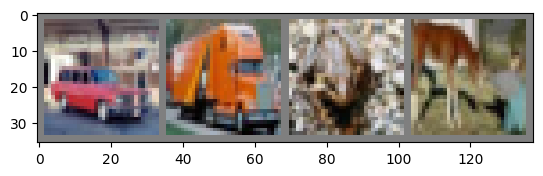

car   truck frog  horse


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [21]:
print(trainset)
print('-'*100)
print(testset)
print('-'*100)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
----------------------------------------------------------------------------------------------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
----------------------------------------------------------------------------------------------------


In [22]:
## 1번 배치사이즈 자료 확인
## 2개 : 이미지 + 라벨
## 0번 자료는 이미지 : 4개 배치, 32*32*3
## 1번 자료에는 라벨 4개

first_batch = trainloader.__iter__().__next__()
len(first_batch), first_batch[0].shape, first_batch[1].shape

(2, torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [25]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()    # 작업순서 1번
        self.conv1 = nn.Conv2d(3, 6, 5)   # in 3, out 6, 커널 5, stride 1, padding O=valid --> 작업순서 2번 사용
        self.pool = nn.MaxPool2d(2, 2)    # 작업순서 3번 사용
        self.conv2 = nn.Conv2d(6, 16, 5)  # 작업순서 4번에 사용
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # conv2에서 out 16, 5*5인 in값, out 120개
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 작업순서 2번 in채널 3, out채널 6인 5*5커널 제작, 스트라이드1, 패딩0
        x = self.pool(F.relu(self.conv2(x)))  # 작업순서 3번 2번에서 받은 결과물 6채널, 28*28인 자료를 relu함수로 계산하고, pool하자
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)   # 맨 마지막 outut은 무조건 클래스 개수와 일치(레이블개수, y레이블값의 유니크 개수, maxt숫자값)
        return x


net = Net()

In [32]:
### 참고용  view = np.reshape와 같음
# x=torch.randn(4,4)
# x.view(16), x.view(8,-1)

(tensor([-0.1632,  0.3979, -1.1107,  0.4566, -1.2349, -0.7770, -0.4652,  0.3668,
         -1.1861, -0.1104, -0.5497,  1.0145, -1.7763, -0.4323, -0.5649, -0.3763]),
 tensor([[-0.1632,  0.3979],
         [-1.1107,  0.4566],
         [-1.2349, -0.7770],
         [-0.4652,  0.3668],
         [-1.1861, -0.1104],
         [-0.5497,  1.0145],
         [-1.7763, -0.4323],
         [-0.5649, -0.3763]]))

In [26]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [27]:
!pip install torchsummary

In [28]:
import torchsummary
torchsummary.summary(net,(3,32,32)) # 파라미터 값 = ((커널사이즈(x*y)*in값) + bios(1))*out값

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [35]:
imgArry=first_batch[0][0]
np.shape(net.conv1(imgArry)), np.shape(net.pool(imgArry)), np.shape(net.conv2(net.pool(net.conv1(imgArry))))

(torch.Size([6, 28, 28]), torch.Size([3, 16, 16]), torch.Size([16, 10, 10]))

In [37]:
tmp=net.pool(net.conv2(net.pool(net.conv1(imgArry))))
tmp.size()

torch.Size([16, 5, 5])

In [38]:
net.named_parameters()

<generator object Module.named_parameters at 0x7fd190246570>

In [39]:
# 가중치와 편향 출력
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.data)


conv1.weight tensor([[[[ 0.0371,  0.0147, -0.0751,  0.0814,  0.0244],
          [ 0.0019,  0.0066,  0.0890,  0.0578, -0.0386],
          [-0.0644,  0.0218,  0.0355,  0.1030,  0.1051],
          [ 0.0729,  0.0750,  0.0950, -0.0576,  0.0844],
          [-0.0780,  0.0562, -0.0489, -0.1124, -0.0870]],

         [[-0.0834, -0.0114,  0.0260,  0.0639,  0.0995],
          [-0.0846,  0.0799,  0.0020, -0.0957, -0.0961],
          [ 0.1137, -0.0659, -0.0222, -0.0834, -0.0509],
          [-0.0975, -0.0775, -0.0630, -0.0278, -0.0435],
          [-0.0450, -0.0950, -0.0033,  0.0171, -0.0237]],

         [[-0.0272,  0.1130,  0.0976,  0.0752,  0.0854],
          [-0.1090,  0.0373,  0.0055,  0.0494, -0.0657],
          [ 0.0611,  0.0055,  0.0888, -0.0691, -0.0564],
          [-0.0173, -0.0574,  0.0674, -0.1153,  0.0244],
          [-0.0243, -0.0205,  0.0871,  0.0996, -0.0368]]],


        [[[ 0.0407,  0.0570,  0.0563, -0.1071, -0.0316],
          [ 0.0964, -0.0058, -0.0471, -0.0250,  0.0962],
          

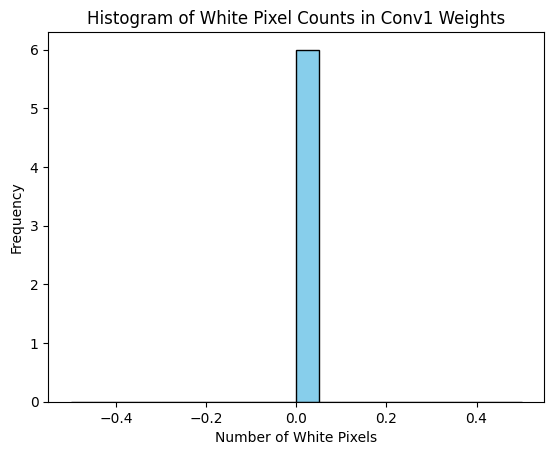

In [40]:
# 첫 번째 합성곱 층의 가중치 가져오기
conv1_weights = net.conv1.weight.data

# 흰색 영역 픽셀 값 추출
white_pixel_counts = []
for i in range(conv1_weights.size(0)):
    weights = conv1_weights[i].view(-1)  # 각 필터의 가중치를 1차원으로 펼침
    white_pixel_count = (weights > 0.9).sum().item()  # 0.9보다 큰 값(흰색)의 픽셀 수 계산
    white_pixel_counts.append(white_pixel_count)

# 히스토그램 그리기
plt.hist(white_pixel_counts, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of White Pixel Counts in Conv1 Weights')
plt.xlabel('Number of White Pixels')
plt.ylabel('Frequency')
plt.show()

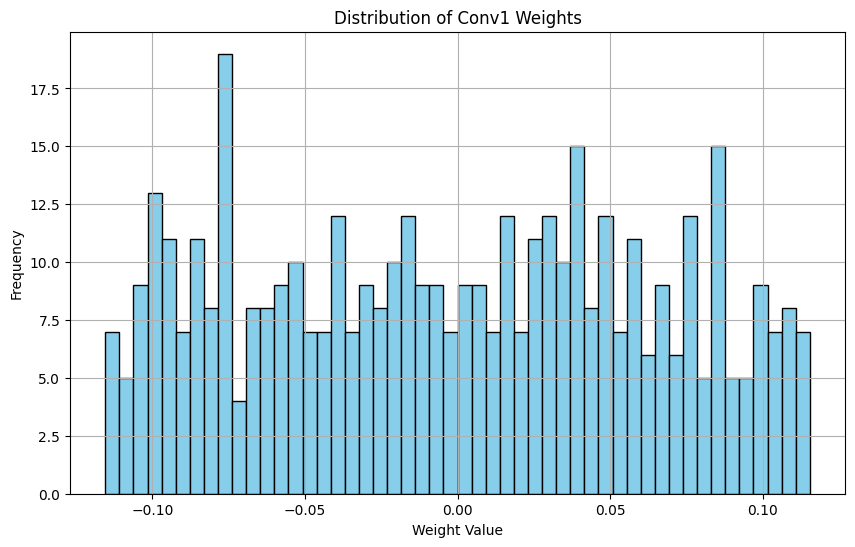

In [41]:
# 가중치 값들을 1차원으로 펼치기
weights_flat = conv1_weights.view(-1).cpu().numpy()

# 가중치 값들의 분포를 히스토그램으로 시각화
plt.figure(figsize=(10, 6))
plt.hist(weights_flat, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Conv1 Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

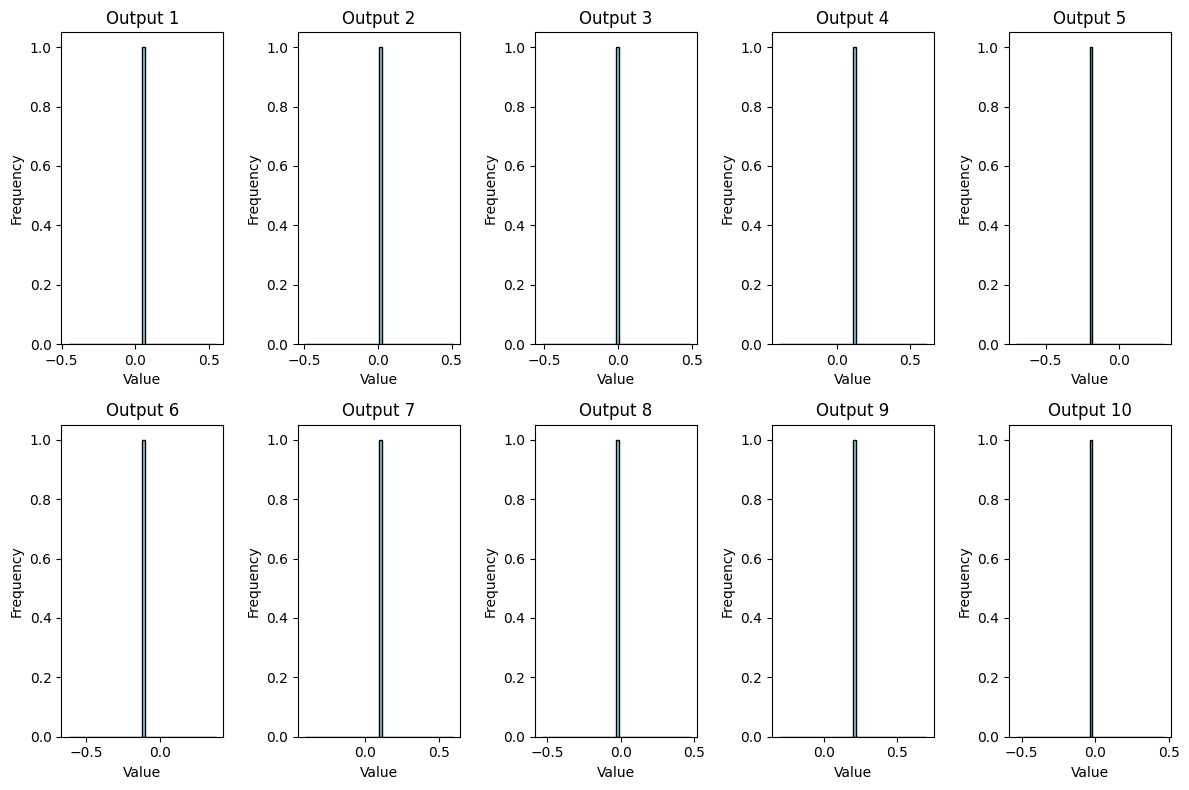

In [42]:
# 예측을 위해 임의의 입력 데이터 생성 (예: 랜덤 노이즈)
input_data = torch.randn(1, 3, 32, 32)  # 크기가 1x3x32x32의 랜덤 입력

# 모델에 입력 데이터 전달하여 출력 계산
output = net(input_data)

# 모든 출력의 가중치 값 시각화
plt.figure(figsize=(12, 8))
for i in range(output.size(1)):  # 모든 출력에 대해 반복
    plt.subplot(2, 5, i + 1)
    output_i = output[0, i].detach().cpu().numpy()  # 해당 출력을 numpy 배열로 변환
    plt.hist(output_i.flatten(), bins=50, color='skyblue', edgecolor='black')  # 히스토그램 그리기
    plt.title(f'Output {i+1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [43]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # 3개 이상의 결과값은
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [44]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.158
[1,  4000] loss: 1.792
[1,  6000] loss: 1.625
[1,  8000] loss: 1.547
[1, 10000] loss: 1.499
[1, 12000] loss: 1.465
[2,  2000] loss: 1.348
[2,  4000] loss: 1.339
[2,  6000] loss: 1.329
[2,  8000] loss: 1.331
[2, 10000] loss: 1.288
[2, 12000] loss: 1.286
Finished Training
